In [1]:
#####################################################################
## The method of calculation noise is translated from Loomis et al. 2020 (Nature Astronomy, 5, 18).
## 
## mark molecule names above the transition 
## -- ZP Kou, 12.22. 2024
#####################################################################

In [2]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.cluster import DBSCAN
import os
import glob
import re

In [11]:
# process observation files
def obs_file(obs_file_path):


    x_data_obs = []
    y_data_obs = []
    column1_data_37 = []
    column2_data_37 = []

    with open(obs_file_path, 'r') as file_37:
        lines_37 = file_37.readlines()
        for line_37 in lines_37[11:]:
            columns_37 = line_37.split()
            column1_data_37.append(columns_37[0])
            column2_data_37.append(columns_37[1])

    for x, y in zip(column1_data_37, column2_data_37):
        temp_x = float(x)
        temp_y = float(y)
        x_data_obs.append(temp_x)
        y_data_obs.append(temp_y)

    x_data_obs = np.array(x_data_obs)
    y_data_obs = np.array(y_data_obs)

    return x_data_obs, y_data_obs


# process model files
def model_mole(datafile, spw=None):


    molecule_name = []
    x_fit = np.array([], dtype=np.float64)
    y_fit = np.array([], dtype=np.float64)
    with open(datafile+f'/'+'xclass_spectrum_output.dat', 'r') as file1:   # TODO
        line_1 = file1.readlines()
        for line in line_1:
            colums_1 = line.split()
            x_fit = np.append(x_fit, float(colums_1[0]))
            y_fit = np.append(y_fit, float(colums_1[1]))

    files = glob.glob(datafile + "*.molfit")

    for file_path in files:
        with open(file_path, 'r') as file:
            for line in file:
                if line.startswith('%')  or line.strip() == '':
                    continue
                molecule_info = '; '.join(line.split(';')[0:2])  
                molecule_name.append(molecule_info)  
                break    

    return  molecule_name, x_fit, y_fit  



# identify max point of lines
def line_mark(y_obs_data, molecule_name, x_mol_data, y_mol_data, gap=None):


    max_values = {}
    groups = {}
    
    def calc_noise_std(spectrum):

        dummy_ints = np.copy(spectrum)
        noise = np.copy(spectrum)

        dummy_std = np.nanstd(dummy_ints)

        # repeats 3 times to make sure to avoid any interloping lines
        for chan in np.where(dummy_ints < (-dummy_std*1.))[0]:
            noise[chan-10:chan+10] = np.nan
        for chan in np.where(dummy_ints > (dummy_std*1.))[0]:
            noise[chan-10:chan+10] = np.nan
        noise_mean = np.nanmean(noise)
        noise_std = np.nanstd(np.real(noise))
    
        for chan in np.where(dummy_ints < (-noise_std*3.5))[0]:
            noise[chan-10:chan+10] = np.nan
        for chan in np.where(dummy_ints > (noise_std*3.5))[0]:
            noise[chan-10:chan+10] = np.nan
        noise_mean = np.nanmean(noise)
        noise_std = np.nanstd(np.real(noise))

        for chan in np.where(dummy_ints < (-dummy_std*3.5))[0]:
            noise[chan-10:chan+10] = np.nan
        for chan in np.where(dummy_ints > (dummy_std*3.5))[0]:
            noise[chan-10:chan+10] = np.nan
        noise_mean = np.nanmean(noise)
        noise_std = np.nanstd(np.real(noise))

        return noise_mean, noise_std
    
    noise_mean, noise_std = calc_noise_std(y_obs_data)
    x_line_mark = []
    y_line_mark = []
    y_obs_mark = []

    y_obs_data = np.interp(np.linspace(0, len(y_obs_data)-1, len(y_mol_data)), np.arange(len(y_obs_data)), y_obs_data)

    for i, j, k in zip(x_mol_data, y_mol_data, y_obs_data):
        if j > 3.0*noise_std:
            x_line_mark.append(i)
            y_line_mark.append(j)
            y_obs_mark.append(k)

    data = np.array(list(zip(x_line_mark, y_line_mark, y_obs_mark)))

    if data.size != 0:
        db = DBSCAN(eps=gap, min_samples=1).fit(data[:, 0].reshape(-1, 1)) 
        labels = db.labels_
        for i, label in enumerate(labels):
            if label not in groups:
                groups[label] = {'x_freq': [], 'y_inte': [], 'y_obs_mark': []}
            groups[label]['x_freq'].append(data[i][0])
            groups[label]['y_inte'].append(data[i][1])
            groups[label]['y_obs_mark'].append(data[i][2])


        for label, values in groups.items():
            y_values = values['y_inte']
            x_values = values['x_freq']
            y_obs_values = values['y_obs_mark']

            max_y_index = y_values.index(max(y_values))
            
            max_values[label] = (molecule_name[0], x_values[max_y_index], y_values[max_y_index], y_obs_values[max_y_index])
            
    return molecule_name, max_values


def plot(obs_file_path, source_name, spw=None, distance=None, mark_file=None, data_dir=None, save=False):


    x_obs, y_obs = obs_file(obs_file_path)

    molecule_name_temp = []
    x_fit_temp = []
    y_fit_temp = []
    x_fit_list = []  
    y_fit_list = []  

    for filename in os.listdir(data_dir):
        if filename.startswith('.'):
            continue

        file_path = os.path.join(data_dir, filename)
        molecule_name, x_fit, y_fit = model_mole(file_path + '/', spw=spw)
        molecule_name_temp.append(molecule_name)
        x_fit_temp.append(x_fit)
        y_fit_temp.append(y_fit)

        x_fit_temp_1 = np.array([], dtype=np.float64)
        y_fit_temp_1 = np.array([], dtype=np.float64)

        with open(file_path + f'/xclass_spectrum_output.dat', 'r') as file1:  
            lines = file1.readlines()
            for line in lines:
                columns = line.split()
                x_fit_temp_1 = np.append(x_fit_temp_1, float(columns[0]))
                y_fit_temp_1 = np.append(y_fit_temp_1, float(columns[1]))

        x_fit_list.append(x_fit_temp_1)
        y_fit_list.append(y_fit_temp_1)


    if not os.path.exists(mark_file):
        os.makedirs(mark_file)
    for i in range(len(molecule_name_temp)):
        molecule_name, max_values = line_mark(y_obs, molecule_name_temp[i], x_fit_temp[i], y_fit_temp[i], gap=distance)
        output_filename = os.path.join(mark_file, f'{molecule_name[0]}_max_values.txt')
        with open(output_filename, 'w') as output_file:
            if max_values != 0:
                output_file.write("# Molecule Name\tFrequency (MHz)\tIntensity (K)\n")
                for key, value in max_values.items():
                    mol_name, frequency, intensity, obs_mark = value
                    output_file.write(f"{mol_name}\t{frequency}\t{intensity}\t{obs_mark}\n")

    molename = []
    x_mark = []
    y_mark = []
    y_obs_mark = []
    for filename in os.listdir(mark_file):
        if filename.endswith('.txt'):
            file_path = os.path.join(mark_file, filename)
            with open(file_path, 'r') as file:
                if filename.startswith('.'):
                    continue
                for line in file:
                    if line.startswith('#'):
                        continue
                    parts = line.strip().split('\t')
                    # print(parts)
                    molename.append(parts[0])   
                    x_mark.append(float(parts[1]))  
                    y_mark.append(float(parts[2]))      
                    y_obs_mark.append(float(parts[3]))

    mark_dict = {'molename': [], 'x_mark': [], 'y_mark': [], 'y_obs_mark': []}
    mark_dict['molename'] = molename
    mark_dict['x_mark'] = x_mark
    mark_dict['y_mark'] = y_mark
    mark_dict['y_obs_mark'] = y_obs_mark

    sorted_indices = sorted(range(len(mark_dict['x_mark'])), key=lambda i: mark_dict['x_mark'][i])
    mark_dict['molename'] = [mark_dict['molename'][i] for i in sorted_indices]
    mark_dict['x_mark'] = [mark_dict['x_mark'][i] for i in sorted_indices]
    mark_dict['y_mark'] = [mark_dict['y_mark'][i] for i in sorted_indices]
    mark_dict['y_obs_mark'] = [mark_dict['y_obs_mark'][i] for i in sorted_indices]


# ---------------- split observation data ----------------
    mid_index = len(x_obs) // 2
    x_split = x_obs[mid_index]

    x_obs_1, y_obs_1 = x_obs[:mid_index], y_obs[:mid_index]
    x_obs_2, y_obs_2 = x_obs[mid_index:], y_obs[mid_index:]

    x_fit_list_1 = [x[x < x_split] for x in x_fit_list]
    y_fit_list_1 = [y[:len(x[x < x_split])] for x, y in zip(x_fit_list, y_fit_list)]

    x_fit_list_2 = [x[x >= x_split] for x in x_fit_list]
    y_fit_list_2 = [y[-len(x[x >= x_split]):] for x, y in zip(x_fit_list, y_fit_list)]

    # ---------------- re molecular name ----------------
    def re_molename(mark_name):
        def format_sub_sup(match):
            mol = match.group(1)
            num = match.group(2)
            rest = match.group(3)
            if '-' in num:
                num = num.replace('-', ' ')
                return f'$^{{{num}}}${mol}' + rest
            return f'{mol}$_{{{num}}}$' + rest

        def format_sub_sup1(match):
            return f'{match.group(1)}$_{{{match.group(2)}}}$'

        def format_sub_sup2(match):
            return f'{match.group(1)}$_{{{match.group(2)}}}$'

        mol = re.sub(r'([A-Za-z]+)(-\d+)-([A-Za-z])', format_sub_sup, mark_name)
        mol = re.sub(r'([A-Za-z])-(\d+)', format_sub_sup1, mol)
        mol = re.sub(r'([A-Za-z]+)(\d+)', format_sub_sup2, mol)
        return mol

    # ---------------- line mark ----------------
    groups_mark = {}
    if mark_dict['y_mark']:
        x_mark_array = np.array(mark_dict['x_mark']).reshape(-1, 1)
        db = DBSCAN(eps=10, min_samples=1).fit(x_mark_array)
        labels = db.labels_
        for i, label in enumerate(labels):
            if label not in groups_mark:
                groups_mark[label] = {'molename': [], 'x_mark': [], 'y_mark': [], 'y_obs_mark': []}
            groups_mark[label]['molename'].append(mark_dict['molename'][i])
            groups_mark[label]['x_mark'].append(mark_dict['x_mark'][i])
            groups_mark[label]['y_mark'].append(mark_dict['y_mark'][i])
            groups_mark[label]['y_obs_mark'].append(mark_dict['y_obs_mark'][i])

    # ---------------- split x axis ----------------
    groups_mark_1 = {}
    groups_mark_2 = {}
    for key, sub in groups_mark.items():
        if np.mean(sub['x_mark']) < x_split:
            groups_mark_1[key] = sub
        else:
            groups_mark_2[key] = sub

#  --------------------- plot observation and model -------------------------------
    def plot_panel(x_obs, y_obs, x_fit_list, y_fit_list, groups_mark, filename, source_name):
        plt.figure(figsize=(28, 12))
        plt.plot(x_obs, y_obs, color='black', linewidth=1.8, drawstyle='steps-mid', alpha=0.9, label='Observation')
        plt.xlim(min(x_obs), max(x_obs))
        plt.ylim(None, max(y_obs) + 120)
        plt.xlabel("Frequency(MHz)", fontsize=28)
        plt.ylabel("T$_{mb}$(K)", fontsize=28)
        plt.tick_params(axis='both', which='both', labelsize=26)
        plt.text(0.015, 0.90, source_name, fontsize=26, transform=plt.gca().transAxes)

        for i in range(len(x_fit_list)):
            if len(x_fit_list[i]) > 0:
                plt.plot(x_fit_list[i], y_fit_list[i], color='red', linewidth=2.6, alpha=0.70, drawstyle='steps-mid', label='Model' if i == 0 else None)

        plt.legend(fontsize=16)

        #  --------------------- plot line mark ------------------------------- 
        group1 = {}
        group2 = {}
        for key, sub in groups_mark.items():
            if len(sub['molename']) < 2:
                group1[key] = sub
            else:
                group2[key] = sub

        for key, sub in group1.items():
            line_y = max(sub['y_mark'][0], sub['y_obs_mark'][0]) + 15
            plt.plot([sub['x_mark'][0]]*2, [sub['y_mark'][0], line_y], color='blue', alpha=0.5, linestyle='--', linewidth=2)
            plt.text(sub['x_mark'][0] - 5, line_y, re_molename(sub['molename'][0]), color='blue', alpha=1.0, fontsize=15, verticalalignment='bottom', rotation=90)

        for key, sub in group2.items():
            combined = sorted(zip(sub['molename'], sub['x_mark'], sub['y_mark'], sub['y_obs_mark']), key=lambda x: x[2])
            molename, x_mark, y_mark, y_obs_mark = zip(*combined)
            line_length = [y_mark[0]] + [y + (i + 1) * 10 for i, y in enumerate(y_mark[1:])]
            for i in range(len(molename)):
                plt.plot([x_mark[i], x_mark[i]], [y_mark[i], line_length[i]+12], color='blue', alpha=0.5, linestyle='--', linewidth=2)
                plt.text(x_mark[i] - 5, line_length[i]+12, re_molename(molename[i]), color='blue', alpha=0.85, fontsize=10, verticalalignment='bottom', rotation=90)

        if save:
            plt.savefig(f"{filename}.pdf", dpi=600, format='pdf', bbox_inches='tight')
        plt.show()

    plot_panel(x_obs_1, y_obs_1, x_fit_list_1, y_fit_list_1, groups_mark_1, f"{source_name}_panel1", source_name)
    plot_panel(x_obs_2, y_obs_2, x_fit_list_2, y_fit_list_2, groups_mark_2, f"{source_name}_panel2", source_name)   



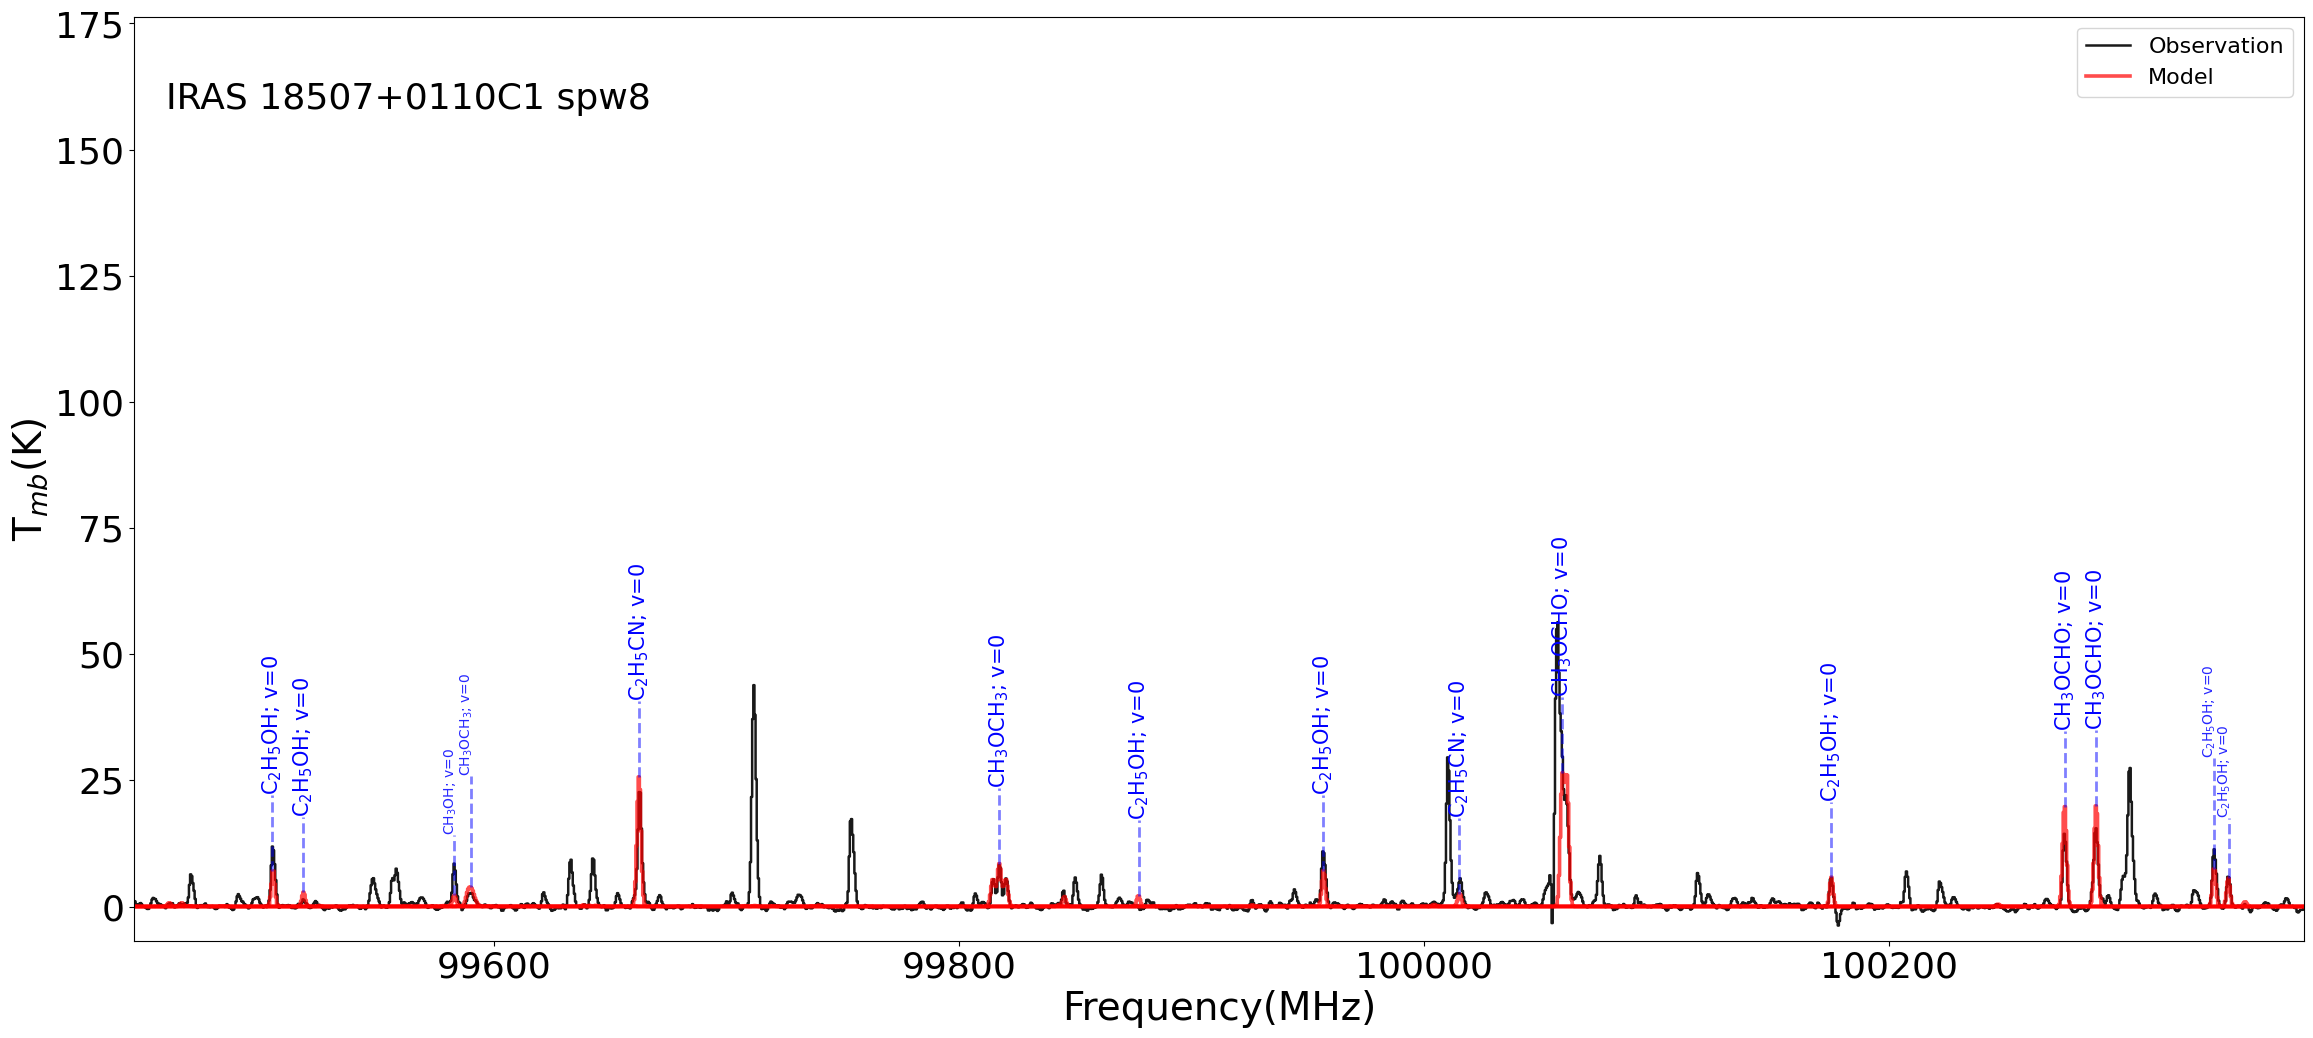

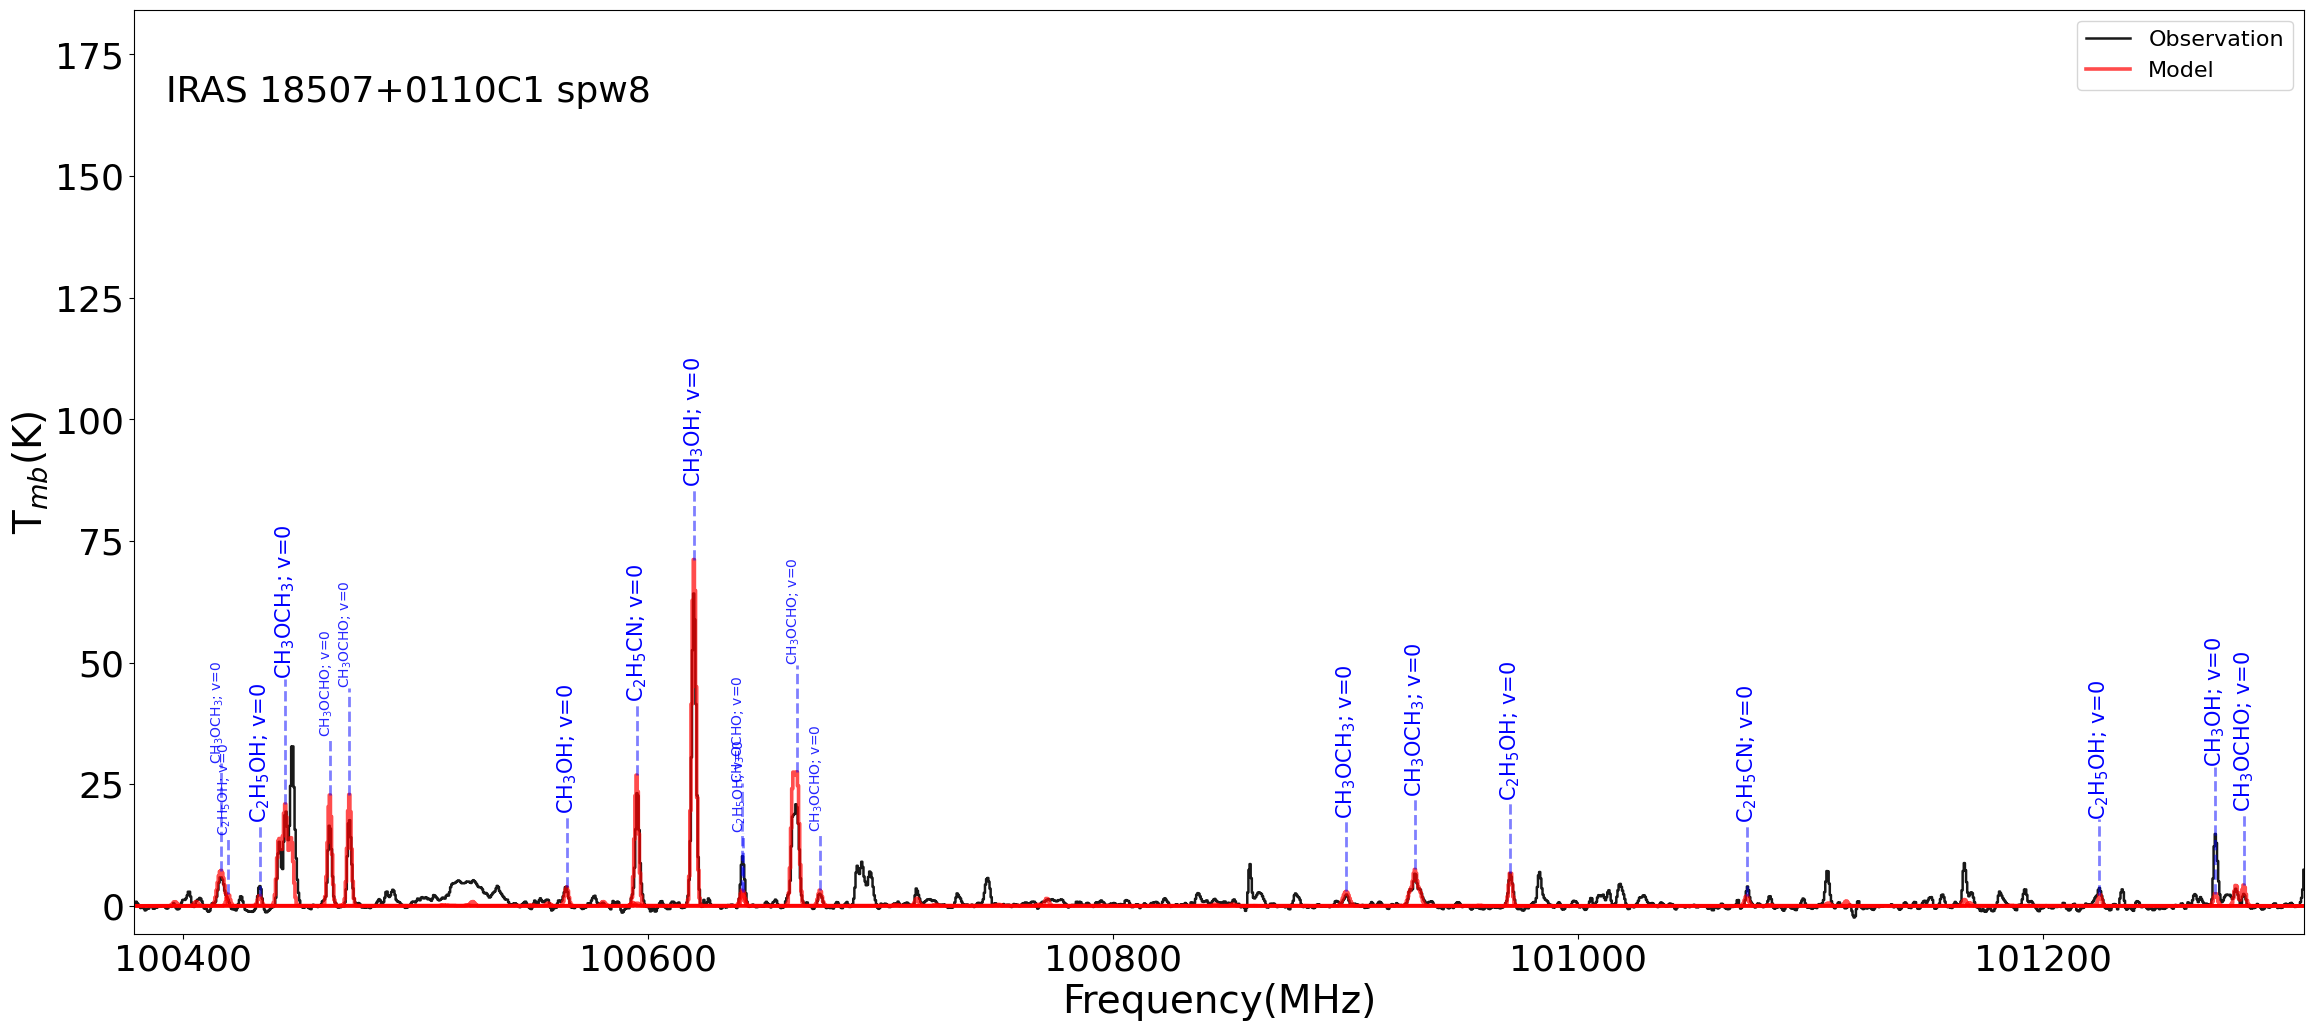

In [13]:
spw = 8
core = 1

file_path=f'./mark/C{core}/spw{spw}'  # save path of marked molecules

# model data file path
data_dir = f"./model_data_source/C{core}/"

plot(obs_file_path = f"./I18507+0110_39.txt", source_name=f'IRAS 18507+0110C{core} spw{spw}',  spw=spw, distance=3, mark_file=file_path, data_dir=data_dir, save=True)  # distance: Starting point to end point of transition line (MHz)